In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [45]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'cpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


np.random.seed(0)
jax.devices()

[CpuDevice(id=0)]

In [46]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full


# Set up test circuits

In [47]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 300
ts = np.linspace(t0, t1, 500)
tmax = 700
dt0 = 0.0005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri5'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01

# MC parameters
total_steps = 5
total_samples = 500
choose_max = int(total_samples * 0.1)
diversity = 0.2  # Sensitivity max to add into next chosen circuits
mutation_scale = 0.1
n_circuits_display = 30
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=total_samples, axis=0)

# Reactions
energies = np.random.rand(total_samples, len(np.tril_indices(len(species_unbound))[0]))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
# forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
forward_rates = forward_rates[0]
# reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# Initialise simulations

In [48]:
sim_func = jax.jit(jax.vmap(
    partial(bioreaction_sim_dfx_expanded,
            t0=t0, t1=t1, dt0=dt0,
            forward_rates=forward_rates,
            inputs=inputs,
            outputs=outputs,
            solver=get_diffrax_solver(
                sim_method),
            saveat=dfx.SaveAt(
                ts=jnp.linspace(t0, t1, 500)),  # int(np.min([500, t1-t0]))))
            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
                                                         choice=stepsize_controller)
            )))
# sol_steady_states = jax.vmap(bioreaction_sim_dfx_expanded)(y00, reverse_rates)
# y01 = np.array(sol_steady_states.ys[:, -1])
# y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
# sol_signal = jax.vmap(bioreaction_sim_dfx_expanded)(y01, reverse_rates)

# Monte Carlo iterations

In [49]:
def choose_next(params, sol, idxs_signal, idxs_output, use_sensitivity_func1: bool, choose_max: int, diversity=0):
    """ Choose circuits with highest adaptability """
    
    def get_next_idxs(analytic, n_chosen):
        idxs_next = jnp.where(jnp.sort(jnp.nanmax(analytic[:, idxs_output], axis=1))[
                            -n_chosen:].min() <= analytic[:, idxs_output])[0]
        return idxs_next

    ys0, ys1 = sol
    adaptability, sensitivity, precision = jax.vmap(partial(
        compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1))(ys0, ys1)
    # idxs_next = jnp.argsort(adaptability[:, idxs_output], axis=0)[-choose_max:]
    if diversity:
        idxs_next_a = get_next_idxs(adaptability, int(np.ceil(choose_max * (1 - diversity))))
        idxs_next_s = get_next_idxs(sensitivity, int(np.floor(choose_max * diversity)))
        # idxs_next_p = get_next_idxs(precision, int(np.floor(choose_max * diversity / 2)))
        idxs_next = jnp.unique(jnp.concatenate([idxs_next_a, idxs_next_s]))
        if len(idxs_next) < choose_max:
            idxs_next = jnp.concatenate([idxs_next, get_next_idxs(adaptability, choose_max - len(idxs_next))])
    else:
        idxs_next = get_next_idxs(adaptability, choose_max)
        
    return idxs_next, adaptability, sensitivity, precision


def mutate_expand(parents: jnp.ndarray, n_samples_per_parent, mutation_scale):
    min_param = parents.min()
    # Generate mutated samples from each parent
    mutated = jax.tree_util.tree_map(
                            lambda x: x + x * mutation_scale * np.random.randn(n_samples_per_parent, *x.shape), parents)
    mutated_nonzero = jnp.where(mutated < min_param, min_param, mutated)

    return mutated_nonzero.reshape(mutated_nonzero.shape[0] * mutated_nonzero.shape[1], *mutated_nonzero.shape[2:])


def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
    ys0, ts0 = simulate_steady_states(
        y0=y00, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    y01 = np.array(ys0[:, -1])
    y01[:, np.array(idxs_signal)] = y01[:, np.array(
        idxs_signal)] * signal_target
    ys1, ts1 = simulate_steady_states(
        y0=y01, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    return ys0, ts0, ys1, ts1



Starting iteration 1 out of 5




Steady states:  300  iterations.  770  left to steady out.  0:01:11.580443
Steady states:  600  iterations.  371  left to steady out.  0:02:52.366947
Done:  0:04:37.289275
Steady states:  300  iterations.  111  left to steady out.  0:01:17.679097
Steady states:  600  iterations.  56  left to steady out.  0:02:37.395456
Done:  0:04:15.737128


Starting iteration 2 out of 5


Steady states:  300  iterations.  1267  left to steady out.  0:01:05.394910
Steady states:  600  iterations.  696  left to steady out.  0:02:10.729075
Done:  0:03:15.985949
Steady states:  300  iterations.  280  left to steady out.  0:01:04.926984
Steady states:  600  iterations.  137  left to steady out.  0:02:11.116367
Done:  0:03:16.713209


Starting iteration 3 out of 5


Steady states:  300  iterations.  1147  left to steady out.  0:01:05.201321
Steady states:  600  iterations.  600  left to steady out.  0:02:09.862212
Done:  0:03:14.599707
Steady states:  300  iterations.  249  left to steady out.  0:01:09.727

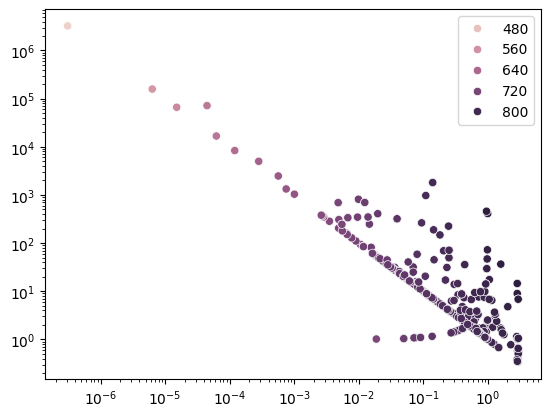

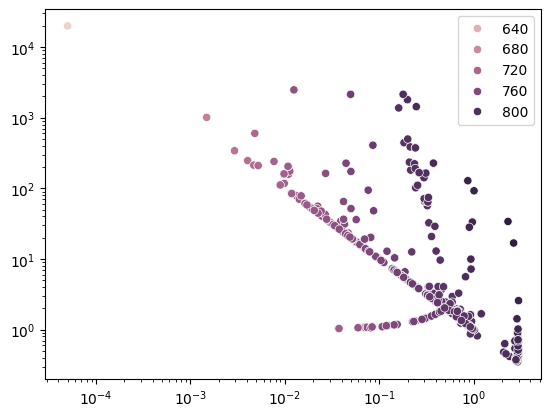

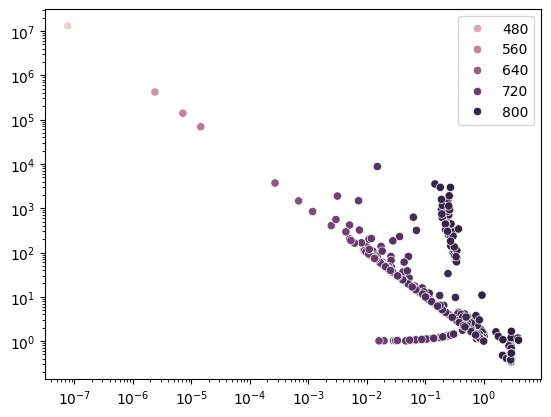

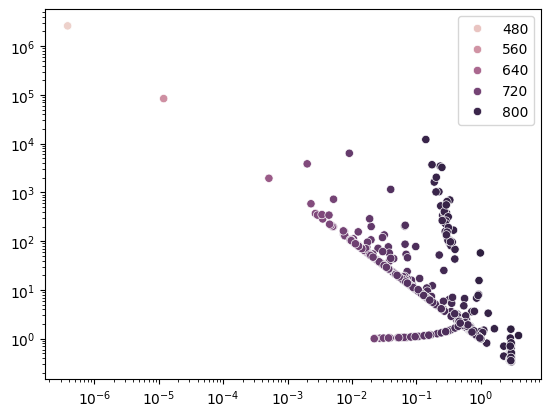

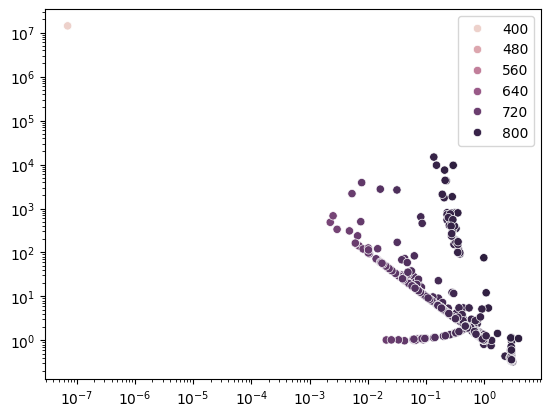

In [50]:
prev_en = energies
n_samples_per_parent = int(np.ceil(total_samples/choose_max))

# [total_steps, n_outputs, n_samples, n_reactions]
all_params_en = np.zeros((total_steps, *reverse_rates.shape))
all_params_eq = np.zeros((total_steps, *reverse_rates.shape))
all_params_rt = np.zeros((total_steps, *reverse_rates.shape))
all_is_parent = np.zeros((total_steps, total_samples), dtype=bool)
all_adaptability = np.zeros((total_steps, total_samples, len(species)))
all_sensitivity = np.zeros((total_steps, total_samples, len(species)))
all_precision = np.zeros((total_steps, total_samples, len(species)))

sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt0,
                            forward_rates=forward_rates,
                            inputs=inputs,
                            outputs=outputs,
                            solver=get_diffrax_solver(sim_method),
                            saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))

for step in range(total_steps):

    print(f'\n\nStarting iteration {step+1} out of {total_steps}\n\n')

    prev_eq = jax.vmap(
        partial(equilibrium_constant_reparameterisation, initial=N0))(prev_en)
    _, prev_rt = eqconstant_to_rates(prev_eq, k_a)

    ys0, ts0, ys1, ts1 = simulate(
        y00, prev_rt, sim_func, t0, t1, tmax, threshold_steady_state)
    next_idxs, adaptability, sensitivity, precision = choose_next(params=prev_rt, sol=(ys0, ys1), idxs_signal=idxs_signal, idxs_output=idxs_output,
                                                                  use_sensitivity_func1=use_sensitivity_func1, choose_max=choose_max, diversity=diversity)
    
    plt.figure()
    sns.scatterplot(x=sensitivity[next_idxs].flatten(), y=precision[next_idxs].flatten(), hue=adaptability[next_idxs].flatten())
    plt.xscale('log')
    plt.yscale('log')

    # Save results
    all_params_en[step] = prev_en
    all_params_eq[step] = prev_eq
    all_params_rt[step] = prev_rt
    all_is_parent[step][next_idxs] = True
    all_adaptability[step] = adaptability
    all_sensitivity[step] = sensitivity
    all_precision[step] = precision

    # Mutate energies
    next_en = mutate_expand(
        prev_en[next_idxs], n_samples_per_parent, mutation_scale)[:total_samples]
    prev_en = next_en

Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

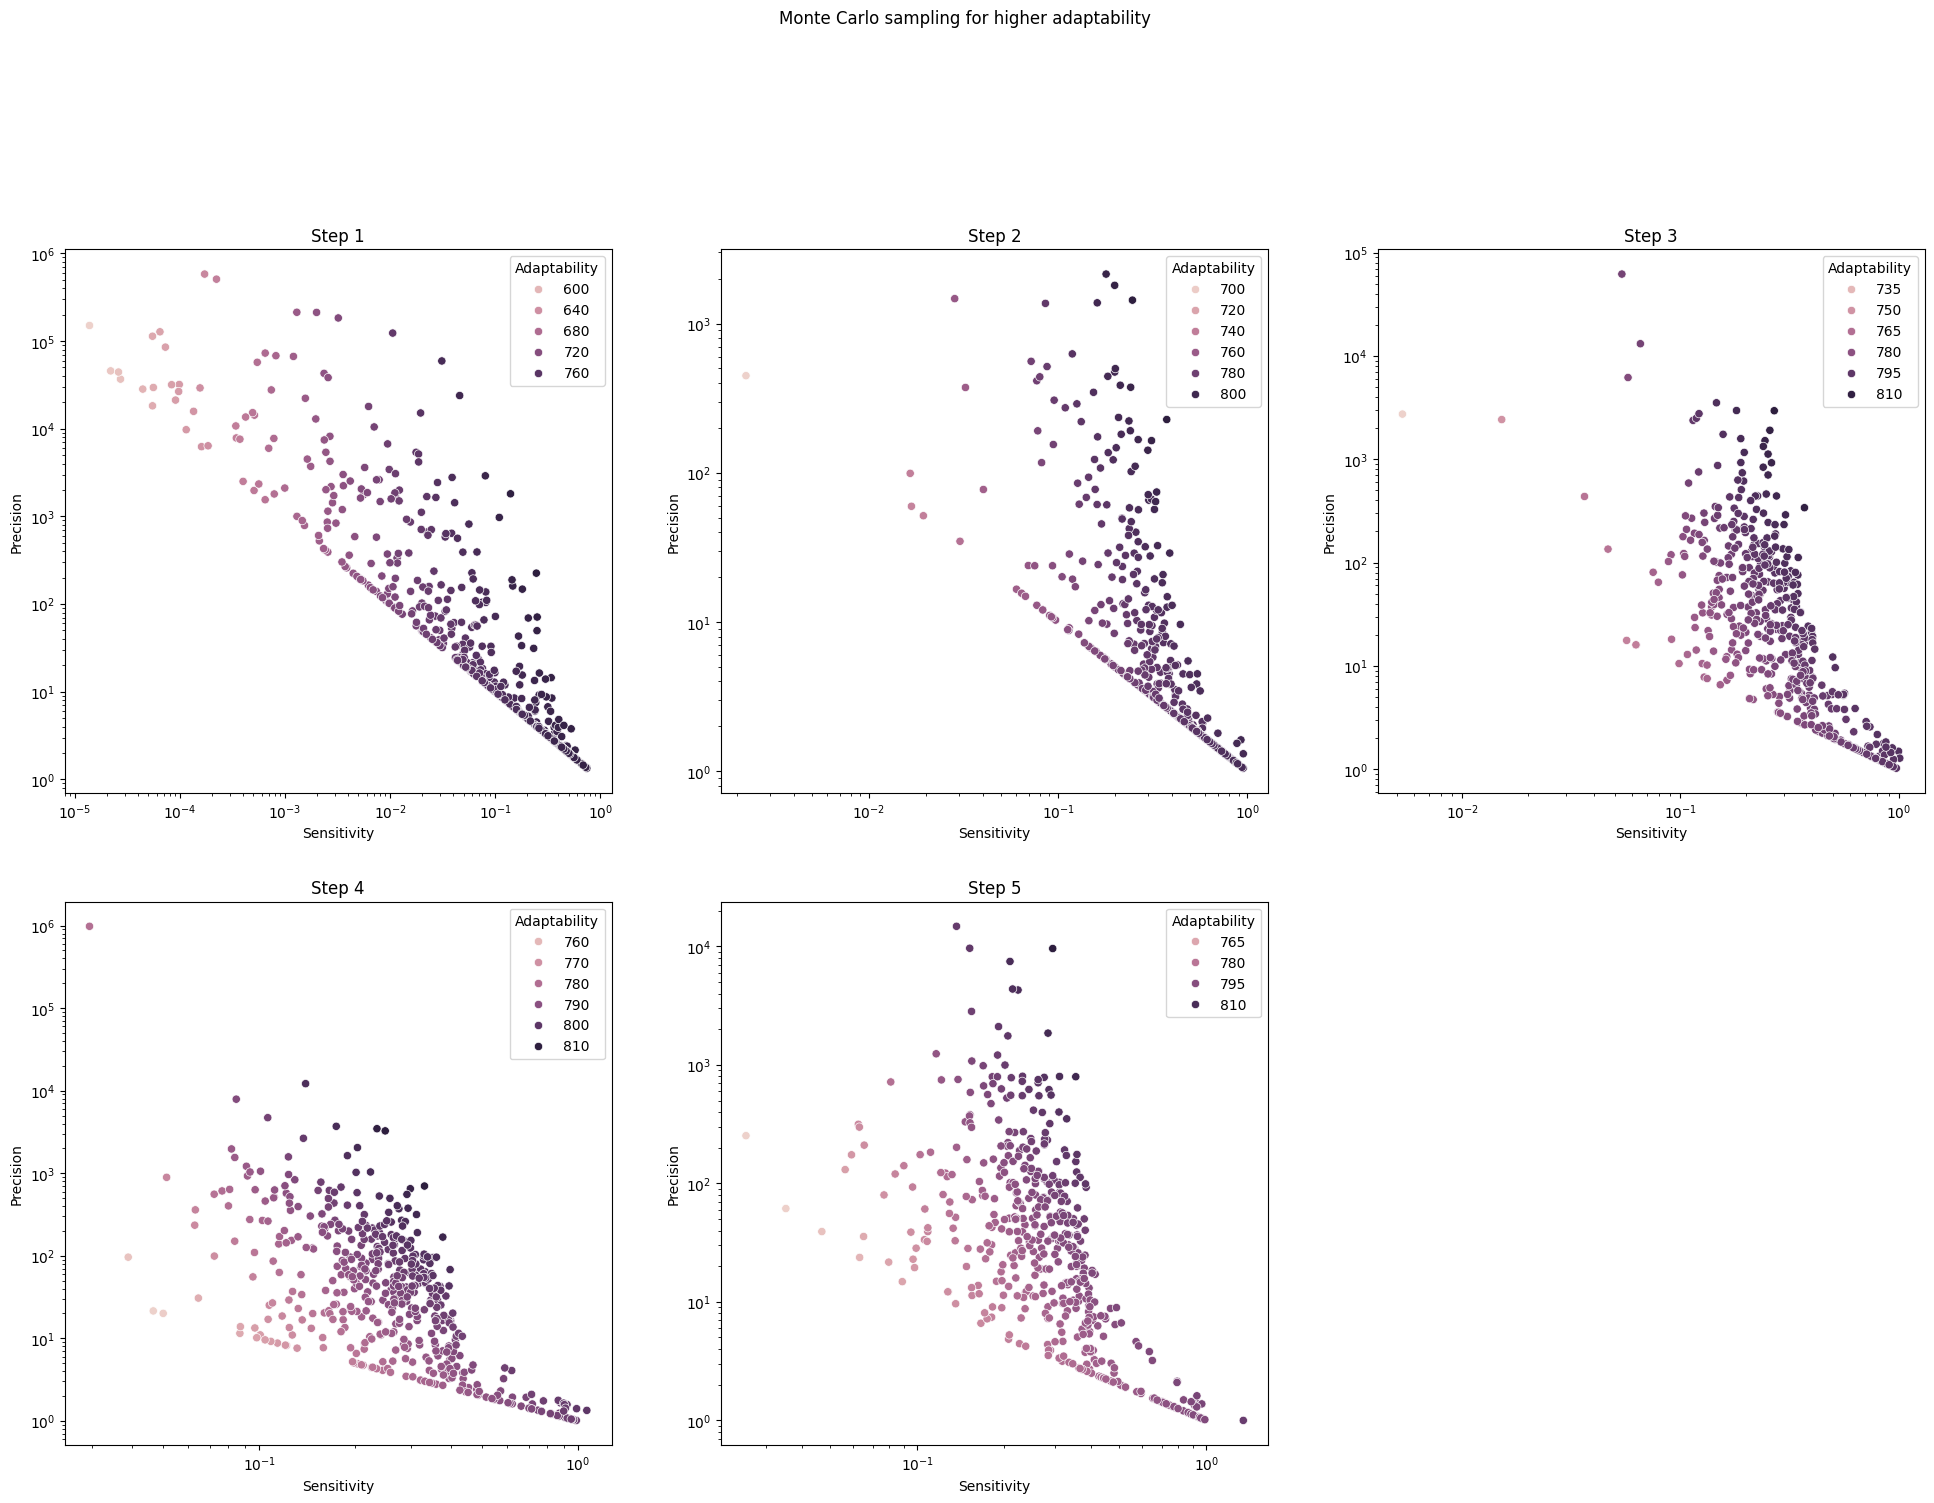

In [51]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
d = pd.DataFrame(data={'Adaptability': all_adaptability[..., idxs_output].flatten(), 
                       'Sensitivity': all_sensitivity[..., idxs_output].flatten(), 
                       'Precision': all_precision[..., idxs_output].flatten(), 
                       'Is parent circuit': np.repeat(all_is_parent.flatten(), repeats=len(species_output)),
                       'Circuit idx': np.repeat(np.repeat(np.arange(total_samples), repeats=len(species_output)), repeats=total_steps),
                       'Species': flatten_listlike([[s] * total_samples for s in species_output] * total_steps),
                       'Step': np.repeat(np.arange(total_steps), repeats=total_samples*len(species_output))})
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {a.max()}, Sensitivity: {s.max()}, Precision: {p.max()}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt], x='Sensitivity', y='Precision', hue='Adaptability')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}')

plt.suptitle('Monte Carlo sampling for higher adaptability')

Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

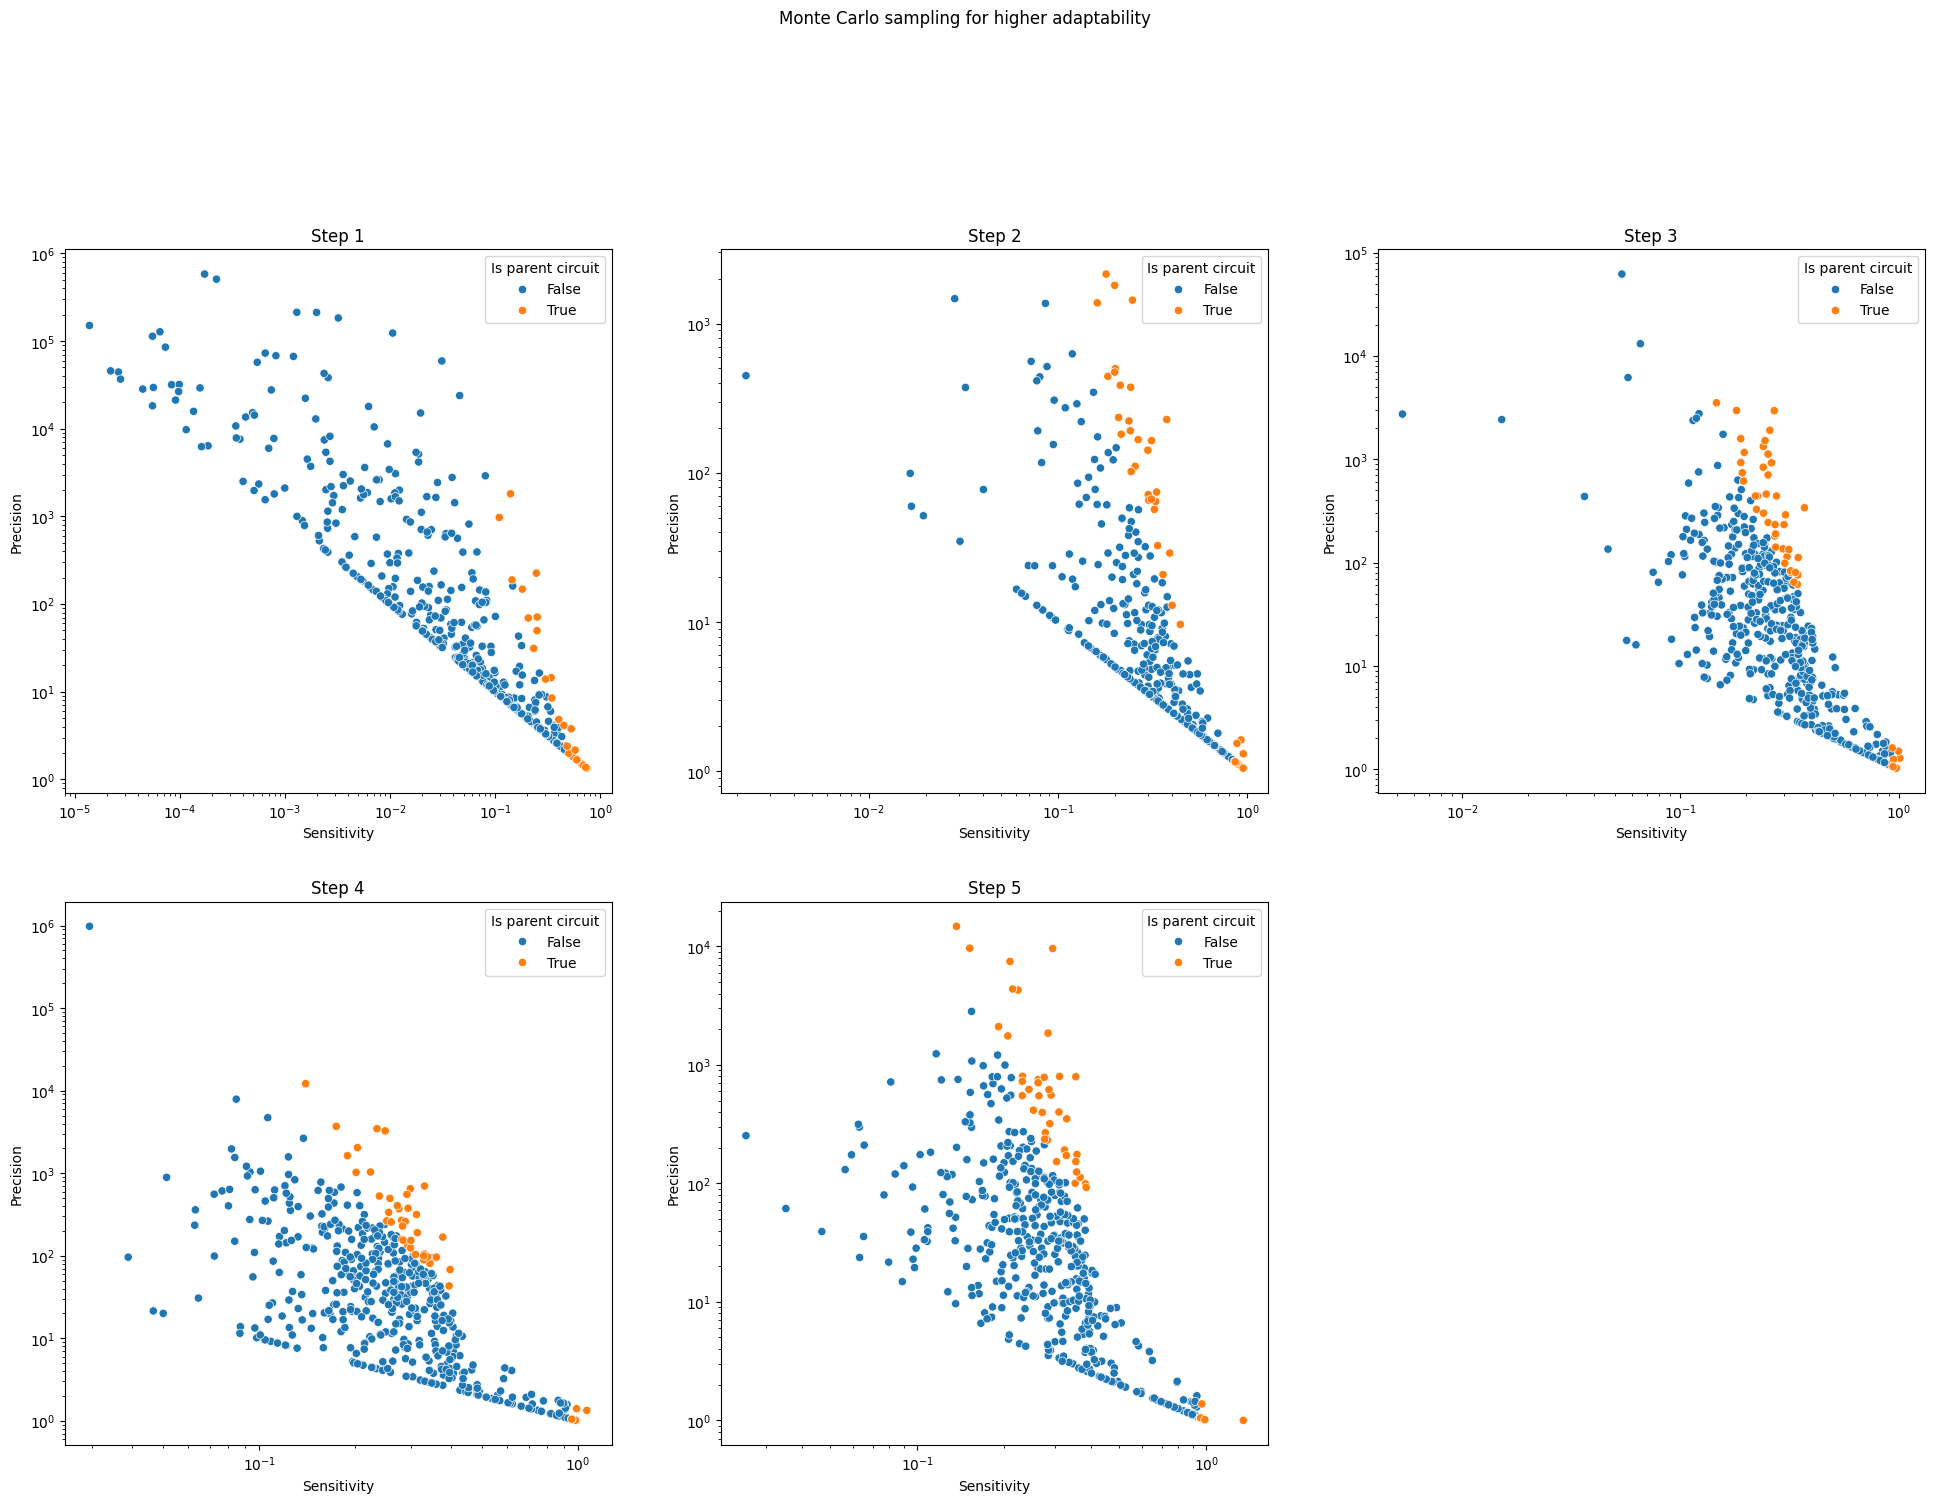

In [52]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {a.max()}, Sensitivity: {s.max()}, Precision: {p.max()}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt].sort_values(by='Is parent circuit'), x='Sensitivity', y='Precision', hue='Is parent circuit')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}')

plt.suptitle('Monte Carlo sampling for higher adaptability')